# HDBSCAN\*

---

In [51]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from itertools import combinations
from scipy.sparse.csgraph import minimum_spanning_tree

np.random.seed(42)

## Introduction

Clustering is a fundamental unsupervised learning task aimed at discovering distinct groups (clusters) within a dataset such that objects within a group are more similar to each other than to those in other groups. While classical parametric methods like K-Means are computationally efficient, they rely on strong assumptions about the data: they assume clusters are hyper-spherical and roughly the same size. This leads to failure when dealing with non-convex shapes (like rings or crescents) or significant noise.

To overcome these limitations, Density-Based Clustering was introduced. The core idea is simple yet powerful: clusters are defined as regions of high density separated by regions of low density. This allows algorithms like DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to identify clusters of arbitrary shape and distinguish them from background noise.

While DBSCAN represented a major leap forward, it suffers from a critical flaw: it relies on a global density threshold, defined by the parameter $\varepsilon$ (epsilon).

This assumes that all clusters in the dataset share the same density characteristics. However, real-world data often contains variable densities (some clusters are tight and dense, while others are diffuse).

- If we set a strict (small) $\varepsilon$ to capture the dense clusters, the sparse clusters are ignored and classified as noise.

- If we set a loose (large) $\varepsilon$ to capture the sparse clusters, the dense clusters are merged together with background noise.

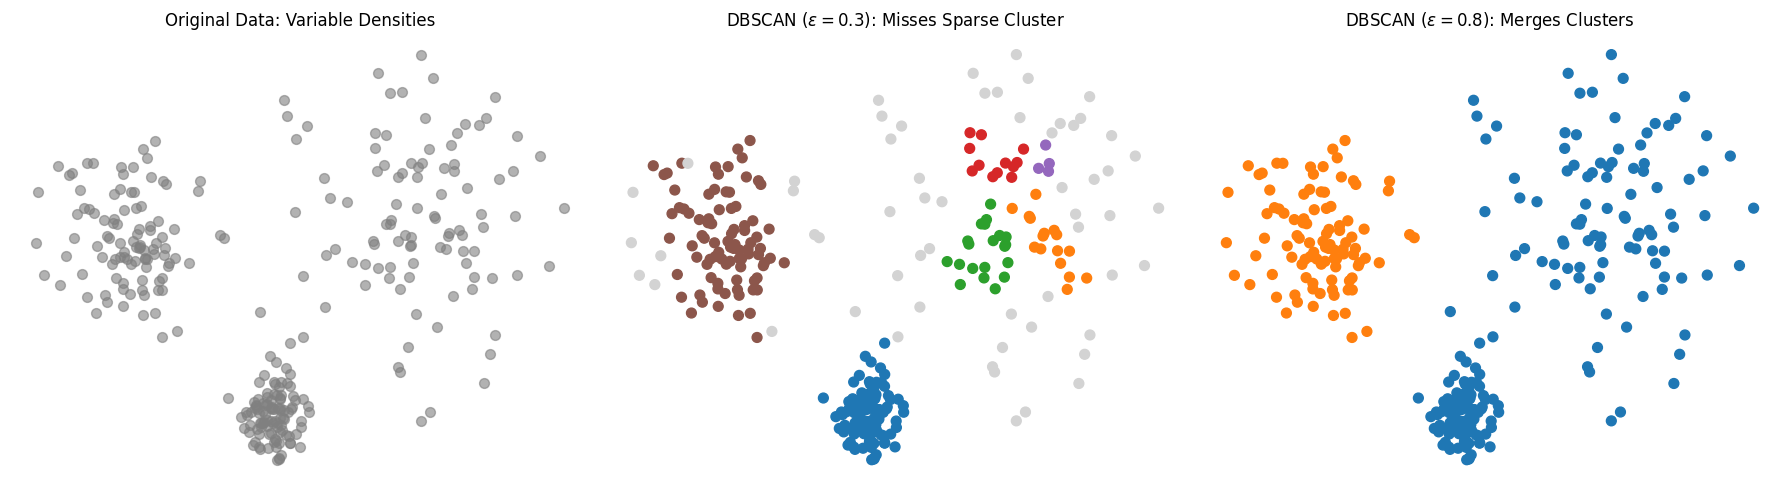

In [52]:
# EXAMPLE: DBSCAN Sensitivity to Variable Densities

# Generate Data with Variable Densities
# Cluster 1: Very dense
blobs_1, _ = make_blobs(n_samples=100, centers=[(0, 0)], cluster_std=0.25)
# Cluster 2: Very sparse
blobs_2, _ = make_blobs(n_samples=100, centers=[(2, 2)], cluster_std=0.9)
# Cluster 3: Intermediate density
blobs_3, _ = make_blobs(n_samples=100, centers=[(-2, 2)], cluster_std=0.5)

X_variable_density = np.vstack([blobs_1, blobs_2, blobs_3])

# Apply DBSCAN with different Epsilons
# Case A: Strict Threshold
db_strict = DBSCAN(eps=0.3, min_samples=5).fit(X_variable_density)

# Case B: Loose Threshold
db_loose = DBSCAN(eps=0.8, min_samples=5).fit(X_variable_density)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(X_variable_density[:, 0], X_variable_density[:, 1], c='gray', s=50, alpha=0.6)
axes[0].set_title("Original Data: Variable Densities")

# Helper function to map labels to distinct colors
def get_colors(labels):
    palette = plt.cm.tab10.colors 
    colors = []
    for label in labels:
        if label == -1:
            colors.append('lightgray')
        else:
            colors.append(palette[label % len(palette)])
    return colors

# Plot Strict DBSCAN
colors_strict = get_colors(db_strict.labels_)
axes[1].scatter(X_variable_density[:, 0], X_variable_density[:, 1], c=colors_strict, s=50)
axes[1].set_title(r"DBSCAN ($\varepsilon=0.3$): Misses Sparse Cluster")

# Plot Loose DBSCAN
colors_loose = get_colors(db_loose.labels_)
axes[2].scatter(X_variable_density[:, 0], X_variable_density[:, 1], c=colors_loose, s=50)
axes[2].set_title(r"DBSCAN ($\epsilon=0.8$): Merges Clusters")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

To address this, we introduce HDBSCAN\* (Hierarchical DBSCAN\*). Instead of forcing a decision with a single global $\varepsilon$, HDBSCAN\* explores the entire range of possible density thresholds simultaneously.

It constructs a hierarchy of all possible clusters (a tree structure) and uses a stability-based optimization method to automatically "cut" the tree at different levels for different branches. This allows it to:

1. Detect clusters of varying densities in a single run.

2. Eliminate the sensitive $\varepsilon$ parameter, replacing it with a more robust $m_{pts}$ (minimum points) parameter.

3. Provide a hierarchical view of the data structure, rather than a flat partition.

In this project, we will replicate the HDBSCAN\* algorithm from scratch, following the theoretical framework established by Campello et al. (2015). We will begin by reviewing the definitions of DBSCAN to understand how HDBSCAN\* evolves these concepts into a rigorous hierarchical model.

## Theoretical Foundations of DBSCAN and DBSCAN\*

Before we can build a hierarchy, we must revisit the definitions of density-based clustering. HDBSCAN\* is built upon DBSCAN\*, a theoretical variation of the classic algorithm.

### Review of DBSCAN

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) is a **non-parametric** algorithm. Unlike GMM, it does not assume a specific functional form for the clusters, enabling it to identify clusters of arbitrary shapes (e.g., non-convex rings or crescents).



The algorithm relies on two hyperparameters:
* **$\varepsilon$ (Epsilon)**: The radius of the neighborhood around a point.
* **$m_{\text{pts}}$**: The minimum number of points required to define a dense region.

We define the $\varepsilon$-neighborhood of a point $x$ as $N_\varepsilon(x)$. Based on this, points are classified into three categories:
* **Core Point**: A point $x$ is a Core point if $|N_\varepsilon(x)| \geq m_{\text{pts}}$.
* **Border Point**: A point that is not a Core point but falls within the neighborhood of a Core point.
* **Noise Point**: A point that is neither a Core point nor a Border point.

DBSCAN defines clusters using the concept of **density reachability**:
* **Directly Density-Reachable**: Point $A$ is directly reachable from $B$ if $B$ is a Core point and $A \in N_\varepsilon(B)$.
* **Density-Connected**: Points $A$ and $B$ are density-connected if there exists a core point $O$ such that both $A$ and $B$ are reachable from $O$.

A **Cluster** is subsequently defined as a maximal set of density-connected points.

**Algorithm**
1.  Mark all points as unvisited.
2.  Randomly select an unvisited point $x$.
3.  Check if $x$ is a Core Point:
    * **If Yes**: Start a new cluster. Perform a graph search (e.g., BFS) to find all points density-connected to $x$ and add them to the cluster.
    * **If No**: Mark $x$ as Noise (note: it may later be reclassified as a Border point if reached by another cluster).
4.  Repeat steps 2 and 3 until all points have been visited.

### Review of DBSCAN\*

**DBSCAN\*** is a variation of the standard DBSCAN algorithm designed to be more consistent with the statistical interpretation of clusters as connected components of a density level set. Like its predecessor, it is a **non-parametric** algorithm capable of identifying clusters of arbitrary shapes.

The algorithm uses the same parameters ($\varepsilon$ and $m_{pts}$), but the point classification is simpler:
* **Core Point**: A point $x$ is a Core point if $|N_\varepsilon(x)| \geq m_{pts}$.
* **Noise Point**: Any point that is not a Core point. This includes points that standard DBSCAN would classify as "Border Points".

Border points technically have low density (lower than $m_{pts}$). Including them makes the cluster definition inconsistent with statistical level sets. By treating everything non-Core as noise, DBSCAN\* defines clusters strictly as the connected components of the high-density level sets.

DBSCAN\* modifies the concept of reachability to be **symmetric**, rather than asymmetric:
* **$\varepsilon$-Reachable**: Two points $x_p$ and $x_q$ are $\varepsilon$-reachable if **both** are Core points and are within distance $\varepsilon$ of each other.
* **Density-Connected**: Two Core points are density-connected if they are directly or transitively $\varepsilon$-reachable.

A **Cluster** is subsequently defined as a connected component of the graph formed by Core points and their $\varepsilon$-reachability relationships.

**Algorithm**
1.  Identify all **Core Points** in the dataset based on $\varepsilon$ and $m_{pts}$.
2.  Construct a graph where every node is a Core Point.
3.  Add edges between nodes if the corresponding Core Points are $\varepsilon$-reachable (within distance $\varepsilon$ of each other).
4.  Find the connected components of this graph; each connected component constitutes a **Cluster**.
5.  Mark all non-core points as **Noise** (conceptually, border objects are not included in the cluster definition, though they can be assigned in a post-processing step if desired).

### DBSCAN vs DBSCAN\* Example

This example visualizes the theoretical distinction between the standard DBSCAN algorithm and its  variant DBSCAN\*, by highlighting their treatment of "border points." Using a dataset with variable density clusters, the visualization demonstrates the "shaving" effect inherent to DBSCAN\*. 

In the left plot (Standard DBSCAN), clusters include border points, objects that fall within the neighborhood of a core point but are not dense enough themselves to be cores. This results in clusters with "fuzzy" edges that extend into lower-density regions . 

In contrast, the right plot (DBSCAN\*) reclassifies these border points as noise (shown in gray), effectively shrinking the clusters to include only their high-density cores. This strict definition ensures that every cluster in DBSCAN\* corresponds to a connected component of a density level set, a necessary condition for building the valid cluster hierarchy required by the HDBSCAN algorithm .

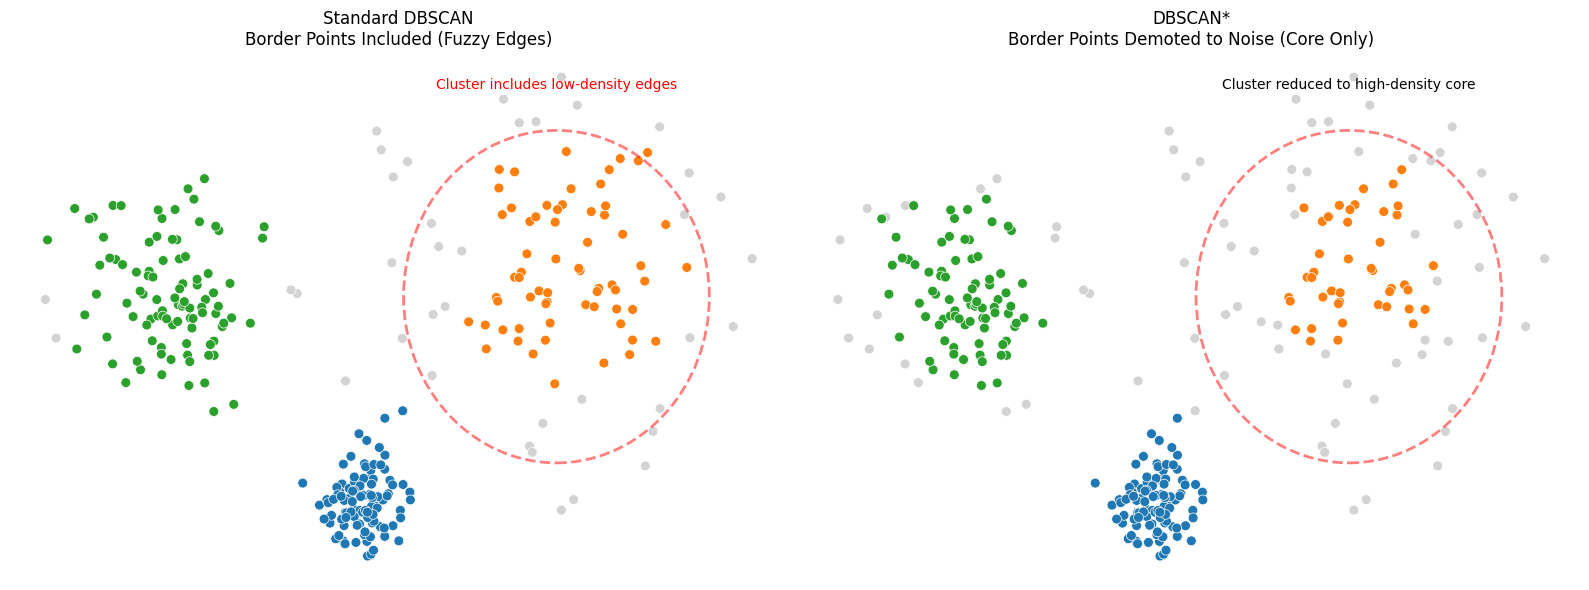

In [53]:
# EXAMPLE: DBSCAN vs DBSCAN\* on Border Points

# Data
X = np.vstack([blobs_1, blobs_2, blobs_3])

# Standard DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X)

# Derive DBSCAN\* Labels
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_standard = db.labels_

labels_star = np.array([label if is_core else -1 
                        for label, is_core in zip(labels_standard, core_samples_mask)])

# Helper for Colors
def get_colors(labels):
    palette = plt.cm.tab10.colors 
    colors = []
    for label in labels:
        if label == -1:
            colors.append('lightgray') # Noise is Gray
        else:
            colors.append(palette[label % len(palette)])
    return colors

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Standard DBSCAN
colors_standard = get_colors(labels_standard)
axes[0].scatter(X[:, 0], X[:, 1], c=colors_standard, s=50, edgecolor='w', linewidth=0.5)
axes[0].set_title(f'Standard DBSCAN\nBorder Points Included (Fuzzy Edges)')

# Plot DBSCAN\*
colors_star = get_colors(labels_star)
axes[1].scatter(X[:, 0], X[:, 1], c=colors_star, s=50, edgecolor='w', linewidth=0.5)
axes[1].set_title(f'DBSCAN*\nBorder Points Demoted to Noise (Core Only)')

for ax in axes:
    circle = plt.Circle((2, 2), 1.6, color='red', fill=False, linestyle='--', linewidth=2, alpha=0.5)
    ax.add_patch(circle)
    ax.axis('off')

axes[0].text(2, 4, "Cluster includes low-density edges", color='red', ha='center', fontsize=10)
axes[1].text(2, 4, "Cluster reduced to high-density core", color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## HDBSCAN\*

We will now implement the algorithm in modular steps, visualizing the effect of each transformation on the data.

### Mutual Reachability Distance

In [54]:
# Sample data
X = np.random.rand(15, 2)

# Parameters for HDBSCAN*
m_pts = 5
p_index = 7
q_index = 10
x_p = X[p_index]
x_q = X[q_index]

The first step of HDBSCAN* is to transform the space to make it more robust to noise. We do this by changing how we measure the "distance" between two points. Instead of standard Euclidean distance, we use a metric that accounts for density called Mutual Reachability Distance. This requires some definitions:

- **Core Distance:** The core distance of an object $x_p \in X$ w.r.t. $m_{\text{pts}}$,
$d_{\text{core}}(x_p)$, is the distance from $x_p$ to its $m_{\text{pts}}$-nearest neighbor (including $x_p$). 

    This acts as an inverse measure of density. Points in dense regions have close neighbors, so their $d_{core}$ is small. Points in sparse regions (noise) have far neighbors, so their $d_{core}$ is large.

In [55]:
def core_distances(X, m_pts):
    '''
    Compute the core distance for each point in X given m_pts.'
    '''

    nbrs = NearestNeighbors(n_neighbors=m_pts, algorithm='kd_tree').fit(X)
    distances, _ = nbrs.kneighbors(X)
    core_dists = distances[:, -1]
    return core_dists

Example of core distance for $m_{\text{pts}} = 5$ in random generated data:

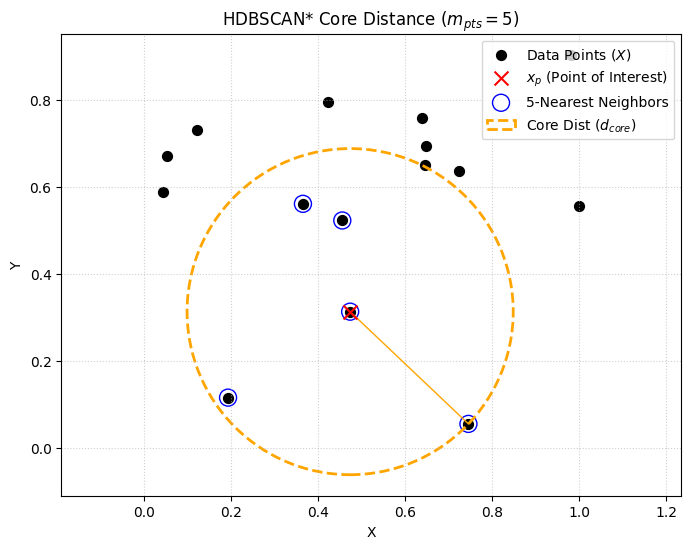

In [56]:
# Core Distance
core_dist = core_distances(X, m_pts)
core_distance_p = core_dist[p_index]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50, label='Data Points ($X$)')
plt.scatter(x_p[0], x_p[1], c='red', marker='x', s=100, label='$x_p$ (Point of Interest)', zorder=10)
neighbor_points = X[np.argsort(np.linalg.norm(X - x_p, axis=1))[:m_pts]]
plt.scatter(neighbor_points[:, 0], neighbor_points[:, 1], s=150, facecolors='none', edgecolors='blue', label=f'{m_pts}-Nearest Neighbors')
circle = plt.Circle((x_p[0], x_p[1]), core_distance_p, color='orange', fill=False, linestyle='--', linewidth=2, label=f'Core Dist ($d_{{core}}$)')
plt.gca().add_patch(circle)
k_neighbor = neighbor_points[-1]
plt.plot([x_p[0], k_neighbor[0]], [x_p[1], k_neighbor[1]], color='orange', linestyle='-', linewidth=1)
plt.title(f'HDBSCAN* Core Distance ($m_{{pts}}={m_pts}$)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

- **Mutual Reachability Distance:** The mutual reachability distance
between two objects $x_p$ and $x_q$ in $X$ w.r.t. $m_{\text{pts}}$ is defined as 

    $$d_\text{mreach}(x_p, x_q) = \max\{d_\text{core}(x_p), d_\text{core}(x_q), d(x_p, x_q)\}$$

    This metric effectively "pushes" points in sparse regions away from everything else. Even if a noise point is physically close to a cluster, its high $d_{core}$ will force the $d_{mreach}$ to be large, making it harder for the algorithm to group it with the cluster.

In [57]:
def mutual_reachability_distance(X, p_index, q_index, core_dists):
    '''
    Compute the mutual reachability distance between points x_p and x_q.
    '''

    core_distance_p = core_dists[p_index]
    core_distance_q = core_dists[q_index]
    euclidean_dist = np.linalg.norm(X[p_index] - X[q_index])
    mreach_dist = max(core_distance_p, core_distance_q, euclidean_dist)
    return mreach_dist

Example of mutual reachability for $m_{\text{pts}} = 5$ in random generated data:

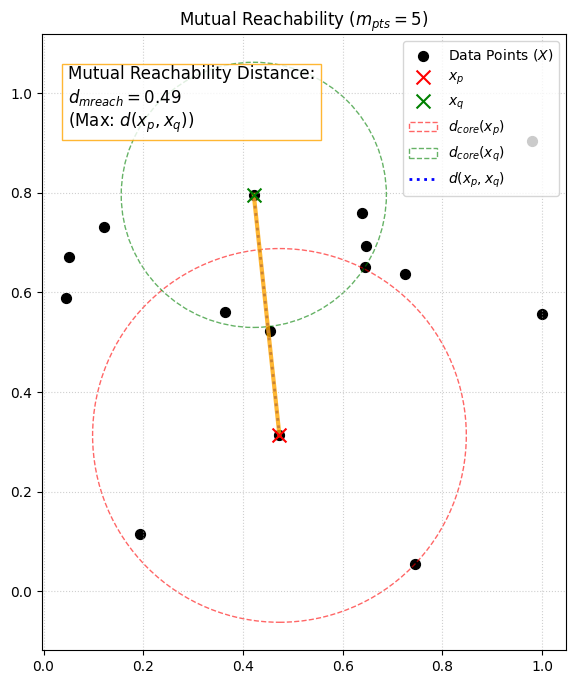

In [58]:
# Core Distance
core_distance_q = core_dist[q_index]

# Mutual Reachability Distance
mreach_dist = mutual_reachability_distance(X, p_index, q_index, core_dist)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50, label='Data Points ($X$)')
ax.scatter(x_p[0], x_p[1], c='red', marker='x', s=100, label='$x_p$', zorder=10)
ax.scatter(x_q[0], x_q[1], c='green', marker='x', s=100, label='$x_q$', zorder=10)
circle_p = plt.Circle(x_p, core_distance_p, color='red', fill=False, linestyle='--', alpha=0.6, label=f'$d_{{core}}(x_p)$')
ax.add_patch(circle_p)
circle_q = plt.Circle(x_q, core_distance_q, color='green', fill=False, linestyle='--', alpha=0.6, label=f'$d_{{core}}(x_q)$')
ax.add_patch(circle_q)
ax.plot([x_p[0], x_q[0]], [x_p[1], x_q[1]], color='blue', linestyle=':', linewidth=2, label=f'$d(x_p, x_q)$')
if mreach_dist == core_distance_p:
    winner_circle = plt.Circle(x_p, core_distance_p, color='orange', fill=False, linewidth=3, alpha=0.8)
    ax.add_patch(winner_circle)
    winner_label = r"Max: $d_{core}(x_p)$"
elif mreach_dist == core_distance_q:
    winner_circle = plt.Circle(x_q, core_distance_q, color='orange', fill=False, linewidth=3, alpha=0.8)
    ax.add_patch(winner_circle)
    winner_label = r"Max: $d_{core}(x_q)$"
else:
    ax.plot([x_p[0], x_q[0]], [x_p[1], x_q[1]], color='orange', linewidth=3, alpha=0.8)
    winner_label = r"Max: $d(x_p, x_q)$"
ax.text(0.05, 0.95, f'Mutual Reachability Distance:\n$d_{{mreach}} = {mreach_dist:.2f}$\n({winner_label})', 
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='orange'), fontsize=12, verticalalignment='top')
ax.set_title(f"Mutual Reachability ($m_{{pts}}={m_pts}$)")
ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.6)
plt.show()

### Mutual Reachability Graph

Now that we have a new way to measure distance ($d_{mreach}$), we can conceptualize the data not as a cloud of points, but as a weighted graph.

The **Mutual Reachability Graph** is a complete graph, $G_{m_\text{pts}}$, in which the objects of $X$ are vertices and the weight of each edge is the mutual reachability distance (w.r.t. $m_\text{pts}$) between the respective pair of objects.

In [59]:
def mutual_reachability_graph(X, weights):
    '''
    Construct the Mutual Reachability Graph for dataset X.
    '''

    n_points = X.shape[0]

    matrix = np.full((n_points, n_points), np.inf)
    for i, j in combinations(range(n_points), 2):
        mreach_dist = mutual_reachability_distance(X, i, j, weights)
        matrix[i, j] = mreach_dist
        matrix[j, i] = mreach_dist

    return matrix

Example of mutual reachability graph for $m_{\text{pts}} = 3$ in random generated data:

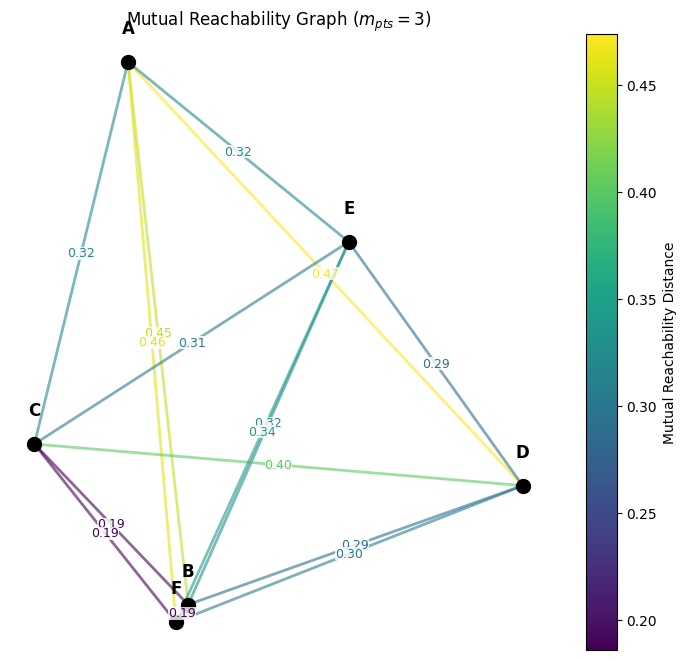

In [60]:
# Generate a small dataset
X = np.random.rand(6, 2)
labels = ['A', 'B', 'C', 'D', 'E', 'F'] 
m_pts = 3

# Mutual Reachability Graph
core_dists = core_distances(X, m_pts)
mreach_dists = mutual_reachability_graph(X, core_dists)

# Plotting
finite_dists = mreach_dists[np.isfinite(mreach_dists)]
vmin = np.min(finite_dists)
vmax = np.max(finite_dists)
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=vmin, vmax=vmax)
for (i, j), dist in np.ndenumerate(mreach_dists):
    if i < j and np.isfinite(dist):
        p1 = X[i]
        p2 = X[j]
        color = cmap(norm(dist))
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, alpha=0.6, linewidth=2, zorder=1)
        mid_x = (p1[0] + p2[0]) / 2
        mid_y = (p1[1] + p2[1]) / 2
        ax.text(mid_x, mid_y, f'{dist:.2f}', fontsize=9, color=color, 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0),
                ha='center', va='center')
for idx, point in enumerate(X):
    ax.scatter(point[0], point[1], c='black', s=100, zorder=2)
    ax.text(point[0], point[1]+0.02, labels[idx], fontsize=12, ha='center', va='bottom', zorder=3, fontweight='bold')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Mutual Reachability Distance')
ax.set_title(f'Mutual Reachability Graph ($m_{{pts}}={m_pts}$)')
ax.set_aspect('equal')
ax.axis('off')

plt.show()

### Minimum Spanning Tree (MST)

To extract the clustering hierarchy, we only need the skeleton of the mutual reachability graph (the subset of edges that connects all points together with the minimum possible total edge weight). This is the **Minimum Spanning Tree (MST)**.

It is mathematically proven that running a Single-Linkage clustering algorithm (which is what we are essentially doing) on the full graph is equivalent to running it on just the MST . By filtering the graph down to $N-1$ edges, we dramatically simplify the problem while retaining all the necessary connectivity information to build the hierarchy.

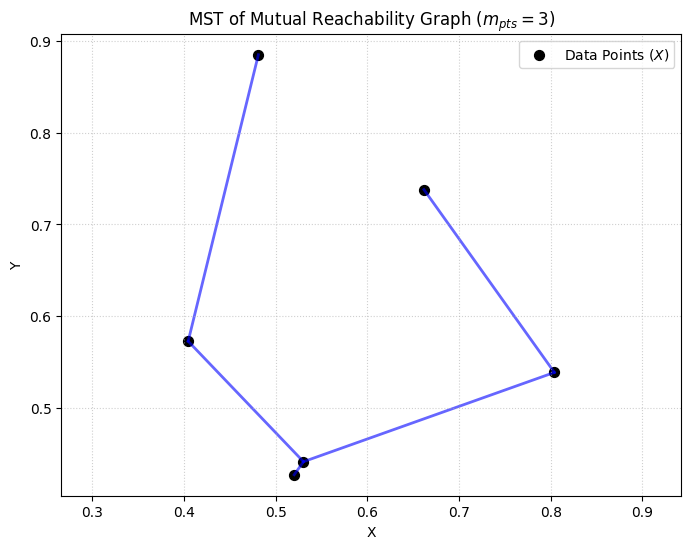

In [61]:
def draw_mst(X, mst):
    '''
    Draw the Minimum Spanning Tree (MST) of the Mutual Reachability Graph.
    '''

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50, label='Data Points ($X$)')
    for i, j in combinations(range(X.shape[0]), 2):
        if mst[i, j] > 0 or mst[j, i] > 0:
            p1 = X[i]
            p2 = X[j]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue', alpha=0.6, linewidth=2, zorder=1)
    plt.title(f"MST of Mutual Reachability Graph ($m_{{pts}}={m_pts}$)")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper right')
    plt.axis('equal')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

mst = minimum_spanning_tree(mreach_dists)
draw_mst(X, mst)

To rigorously account for noise, specifically points that fail the core distance requirement at a given density level, the MST is transformed into an Extended MST ($MST_{ext}$). This involves augmenting the graph by adding a self-loop to every vertex $x_p$, where the weight of the self-loop corresponds to the core distance $d_{core}(x_p)$. These self-edges ensure that the hierarchy captures not just when clusters split, but exactly when a point transitions from being a valid core point to being classified as noise.

In [62]:
def extend_mst(mst, core_dists):
    '''
    Extend the MST by adding self-edges with core distances.
    '''

    n_points = mst.shape[0]
    mst_ext = mst.copy().toarray()

    for i in range(n_points):
        for j in range(n_points):
            if i == j:
                mst_ext[i, i] = core_dists[i]
            elif mst_ext[i, j] == 0:
                mst_ext[i, j] = np.inf

    return mst_ext

mst_ext = extend_mst(mst, core_dists)

### Dendrogram

Having computed the extended MST, $MST_{ext}$, we now possess the "skeleton" of the density landscape. To discover clusters, we must convert this static graph into a hierarchy of connected components. This process is conceptually similar to Single-Linkage Clustering, but it is performed on the transformed Mutual Reachability space. This procedure, detailed as *Algorithm 1* in the primary literature, effectively simulates the execution of DBSCAN* across all possible density thresholds simultaneously.

> **ALGORITHM 1: HDBSCAN\* main steps**

> 1. Compute the core distance w.r.t. $m_{pts}$ for all data objects in $X$.
> 2. Compute an MST of $G_{m_{pts}}$, the Mutual Reachability Graph.
> 3. Extend the MST to obtain $MST_{ext}$, by adding for each vertex a “self edge” with the core distance of the corresponding object as weight.
> 4. Extract the HDBSCAN\* hierarchy as a dendrogram from $MST_{ext}$:
>     1. For the root of the tree assign all objects the same label (single “cluster”).
>     2. Iteratively remove all edges from $MST_{ext}$ in decreasing order of weights (in case of ties, edges must be removed simultaneously):
>         1. Before each removal, set the dendrogram scale value of the current hierarchical level as the weight of the edge(s) to be removed.
>         2. After each removal, assign labels to the connected component(s) that contain(s) the end vertex(-ices) of the removed edge(s), to obtain the next hierarchical level: assign a new cluster label to a component if it still has at least one edge, else assign it a null label (“noise”).


Let's prepare some data for later:

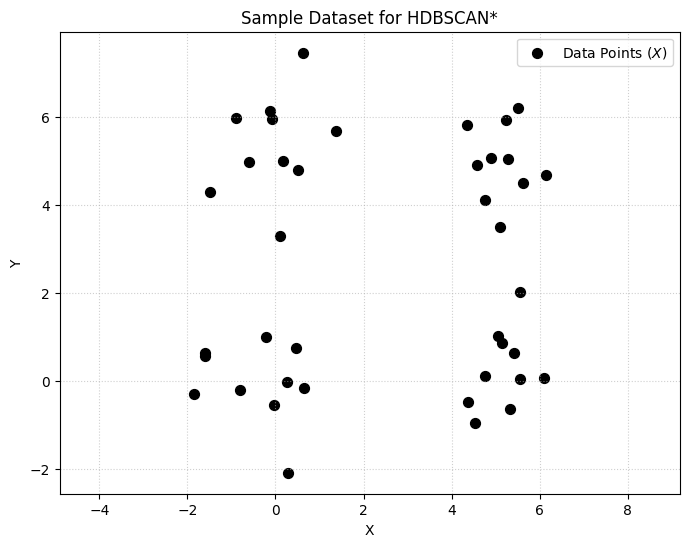

In [63]:
# Generate 4 clusters (2D) for testing
c1  = np.random.randn(10, 2) + np.array([0, 0])
c2  = np.random.randn(10, 2) + np.array([5, 5])
c3  = np.random.randn(10, 2) + np.array([0, 5])
c4  = np.random.randn(10, 2) + np.array([5, 0])
X   = np.vstack((c1, c2, c3, c4))

m_pts = 4

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='black', marker='o', s=50, label='Data Points ($X$)')
plt.title('Sample Dataset for HDBSCAN*')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


def plot_cluster_evolution(hierarchy):
    '''
    Plot the evolution of clusters and noise points across the hierarchy.
    '''

    scales = [h['scale'] for h in hierarchy]
    n_clusters = [h['n_clusters'] for h in hierarchy]
    n_noise = [np.sum(h['labels'] == 0) for h in hierarchy]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel(r'Scale ($\epsilon$)')
    ax1.set_ylabel('Number of Noise Points', color=color)
    ax1.plot(scales, n_noise, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.invert_xaxis() # Hierarchy goes from high scale to low scale

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Number of Clusters', color=color)  
    ax2.step(scales, n_clusters, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Evolution of HDBSCAN* Hierarchy")
    plt.show()

The hierarchy generation proceeds divisively by iteratively removing edges from $MST_{ext}$. The algorithm sorts all edges (including self-loops) in descending order of weight and processes them sequentially:

1. Initialization: The process begins at the root of the hierarchy, where the density threshold is zero (infinite distance). At this stage, all data objects are assigned to a single connected component.

2. Edge Removal: The algorithm iterates through the sorted edges, removing the edge with the current maximum weight. This weight represents the current scale value (density threshold $\varepsilon$) of the hierarchy.

3. Component Evolution: Upon the removal of an edge, the connectivity of the graph is re-evaluated. If the removal causes a connected component to divide, the resulting sub-components are identified as new clusters (children nodes in the dendrogram) for the next hierarchical level.

4. Noise Classification: A critical distinction in HDBSCAN* is the labeling of noise. If a component loses its final edge (including its self-loop) and is reduced to a vertex with no edges, it is assigned a null label, signifying that it has become noise at that specific density scale.

This method yields a complete dendrogram where every level corresponds to a valid DBSCAN* clustering configuration. The resulting tree captures the evolution of density-based structures, documenting how the single global cluster fragments into sub-clusters and eventually dissipates into noise as the density requirement becomes increasingly strict.

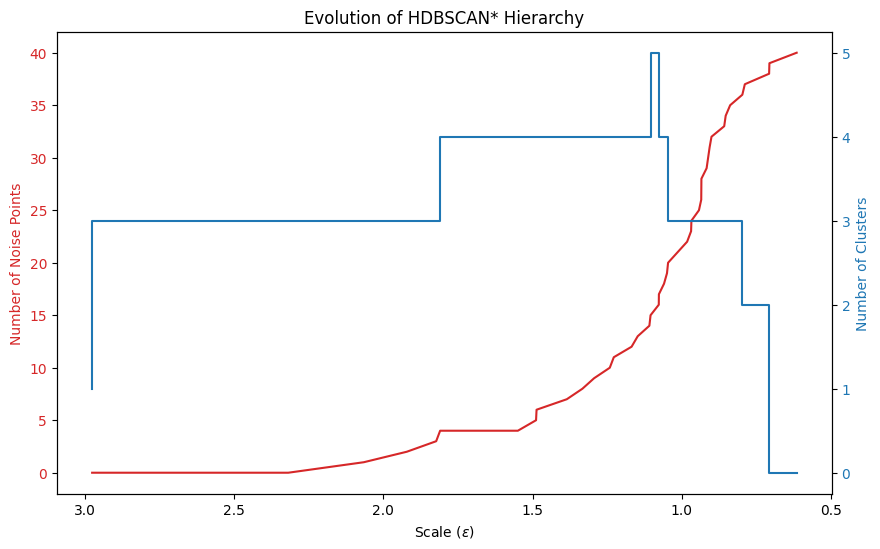

In [64]:
def dendrogram(mst_ext):
    '''
    Generate a dendrogram from the extended MST.
    '''

    n_points = mst_ext.shape[0]

    # Initialize Graph from MST_ext
    G = nx.Graph()
    G.add_nodes_from(range(n_points))
    edges = []
    for i in range(n_points):
        for j in range(i, n_points):
            w = mst_ext[i, j]
            if w < np.inf: 
                G.add_edge(i, j, weight=w)
                edges.append((i, j, w))

    # Sort edges by weight in descending order
    unique_weights = sorted(list(set(w for u, v, w in edges)), reverse=True)
    
    # Initialize lists to store scales and number of clusters
    hierarchy = []
    hierarchy.append({
        'scale': unique_weights[0],
        'n_clusters': 1,
        'labels': np.ones(n_points, dtype=int)
    })

    # Iterating over unique finite weights
    for scale in unique_weights:

        # Remove edges with weight equal to current scale
        edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == scale]
        G.remove_edges_from(edges_to_remove)

        # Find connected components
        components = list(nx.connected_components(G))
        current_labels = np.zeros(n_points, dtype=int)
        
        cluster_id = 1
        for component in components:
            comp_list = list(component)
            subgraph = G.subgraph(comp_list)
            
            if subgraph.number_of_edges() > 0:
                current_labels[comp_list] = cluster_id
                cluster_id += 1

        hierarchy.append({
            'scale': scale,
            'n_clusters': cluster_id - 1,
            'labels': current_labels.copy()
        })

    return hierarchy


core_dists = core_distances(X, m_pts)
mst = minimum_spanning_tree(mutual_reachability_graph(X, core_dists))
mst_ext = extend_mst(mst, core_dists)
hierarchy = dendrogram(mst_ext)
plot_cluster_evolution(hierarchy)

The plot demonstrates that as the density threshold (scale) decreases, the dataset naturally separates into distinct groups, indicated by a stable plateau of clusters over a wide range of scales. The implementation captures the multi-scale density structure of the data, distinguishing between dense cores and sparse noise without requiring a pre-set distance parameter $\varepsilon$.

While the raw hierarchy (dendrogram) provides a complete picture, it is often too complex for direct analysis, containing many splits that are simply individual points detaching from a cluster . To resolve this, *Algorithm 2* introduces a simplification step to condense the hierarchy into a manageable tree of significant clusters.

> **ALGORITHM 2: HDBSCAN\* Step 4.2.2 with (optional) parameter $m_\text{clSize} \geq 1$**

> 4.2.2 After each removal (to obtain the next hierarchical level), process one at a time each cluster that contained the edge(s) just removed, by relabeling its resulting connected subcomponent(s):
>   - Label *spurious* subcomponents as noise by assigning them the null label. 
>   - If all subcomponents of a cluster are *spurious*, then the cluster has disappeared.
>   - Else, if a single subcomponent of a cluster is *not spurious*, keep its original cluster label (cluster has just shrunk).
>   - Else, if two or more subcomponents of a cluster are *not spurious*, assign new cluster labels to each of them (“true” cluster split).


This process relies on a single new parameter: $m_{clSize}$ (Minimum Cluster Size).

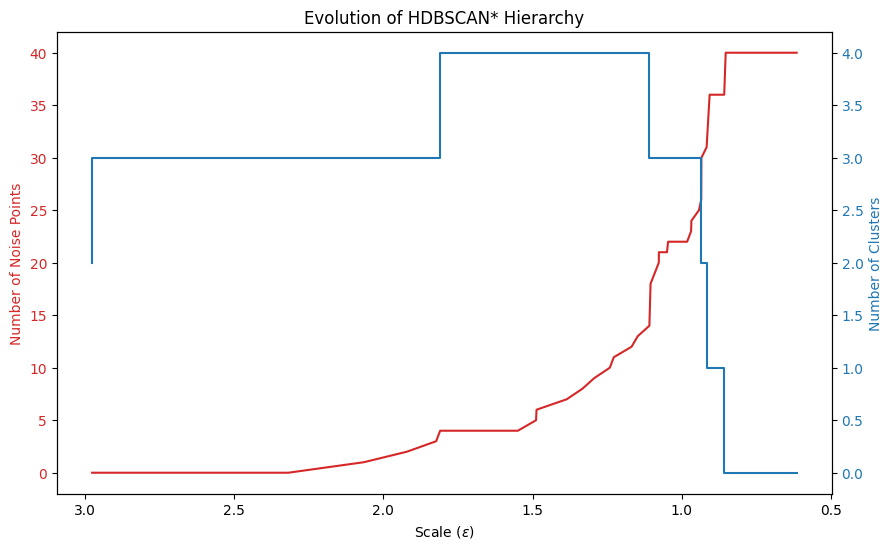

In [65]:
def dendrogram(mst_ext, m_clSize=None):
    '''
    Construct a dendrogram from the extended MST.
    '''    

    n_points = mst_ext.shape[0]

    if m_clSize is None:
        m_clSize = m_pts
    
    # Initialize Graph from MST_ext
    G = nx.Graph()
    G.add_nodes_from(range(n_points))
    edges = []
    for i in range(n_points):
        for j in range(i, n_points):
            w = mst_ext[i, j]
            if w < np.inf: 
                G.add_edge(i, j, weight=w)
                edges.append((i, j, w))
    
    # Sort edges by weight in decreasing order
    unique_weights = sorted(list(set(w for u, v, w in edges)), reverse=True)
    
    # Initialize lists to store scales and number of clusters
    hierarchy = []
    hierarchy.append({
        'scale': np.inf,
        'n_clusters': 1,
        'labels': np.ones(n_points, dtype=int)
    })

    # We assign initial cluster IDs based on the full MST connectivity
    initial_components = list(nx.connected_components(G))
    current_labels = np.zeros(n_points, dtype=int)
    next_cluster_id = 1
    
    # Assign initial labels
    for comp in initial_components:
        if len(comp) >= m_clSize:
            current_labels[list(comp)] = next_cluster_id
            next_cluster_id += 1

    # Iteratively remove all edges
    for scale in unique_weights:

        # Set dendrogram scale value
        
        # Identify edges to remove
        edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] == scale]

        affected_nodes = set()
        for u, v in edges_to_remove:
            affected_nodes.add(u)
            affected_nodes.add(v)

        G.remove_edges_from(edges_to_remove)

        # Find which original clusters were touched
        affected_cluster_ids = set(current_labels[list(affected_nodes)])

        # Ignore noise (0)
        affected_cluster_ids.discard(0) 
        
        # Process only the affected clusters
        for parent_id in affected_cluster_ids:
            
            # Get all nodes currently belonging to this parent cluster
            parent_mask = (current_labels == parent_id)
            parent_nodes = np.where(parent_mask)[0]
            
            # Find the connected sub-components of this cluster in the current graph
            subgraph = G.subgraph(parent_nodes)
            sub_components = list(nx.connected_components(subgraph))
            
            # Classify sub-components as "Valid" or "Spurious"
            valid_sub_comps = []
            spurious_sub_comps = []
            
            for comp in sub_components:
                if len(comp) >= m_clSize:
                    valid_sub_comps.append(list(comp))
                else:
                    spurious_sub_comps.append(list(comp))
        
            # Label spurious subcomponents as noise
            for comp in spurious_sub_comps:
                current_labels[comp] = 0
            
            num_valid = len(valid_sub_comps)
            
            # If all subcomponents are spurious -> Cluster has disappeared
            if num_valid == 0:
                pass # All nodes already set to 0 in step A
                
            # If single subcomponent is not spurious -> Keep original label (Shrunk)
            elif num_valid == 1:
                # The valid component keeps 'parent_id'.
                # The nodes in valid_sub_comps[0] are already labeled 'parent_id',
                # so we do nothing. Spurious ones were set to 0 in step A.
                pass
                
            # If two or more are not spurious -> "True" cluster split
            else:
                # Assign new labels to each valid subcomponent
                for comp in valid_sub_comps:
                    current_labels[comp] = next_cluster_id
                    next_cluster_id += 1
                    
        # Record the state at this scale
        active_clusters = len(np.unique(current_labels[current_labels > 0]))
        
        hierarchy.append({
            'scale': scale,
            'labels': current_labels.copy(),
            'n_clusters': active_clusters
        })

    return hierarchy

hierarchy = dendrogram(mst_ext)
plot_cluster_evolution(hierarchy)

The raw hierarchy generated by *Algorithm 1* provided a mathematically complete but noisy representation of the data's density structure, capturing every detachment of individual points as a split. The implementation of *Algorithm 2* transformed the jittery raw output into a cleaner tree of persistent clusters, isolating the significant density peaks from background noise and preparing the data for the final stability-based extraction step.

### Complete HDBSCAN* Algorithm

Having introduced all the steps of the HDBSCAN* algorithm, we can entirely code it now:

In [66]:
def hdbscan(X, m_pts, m_clSize=None, evolution=False, verbose=False):
    '''
    Perform HDBSCAN* clustering on dataset X with parameter m_pts.
    '''

    # Compute the core distance w.r.t. m_pts for all data objects in X
    dists = core_distances(X, m_pts)
    if verbose:
        print("Core Distances:\n", dists)

    # Compute an MST of G_m_pts, the Mutual Reachability Graph.
    G_m_pts = mutual_reachability_graph(X, dists)
    mst = minimum_spanning_tree(G_m_pts)
    if verbose:
        print("\nMutual Reachability Graph:\n", G_m_pts)
        draw_mst(X, mst)

    # Extend the MST to obtain MST_ext, by adding for each vertex a “self edge” with the core distance of the corresponding object as weight.
    mst_ext = extend_mst(mst, dists)
    if verbose:
        print("\nExtended MST (MST_ext):\n", mst_ext)
    
    # Extract the HDBSCAN* hierarchy as a dendrogram from MST_ext
    hierarchy = dendrogram(mst_ext, m_clSize)
    if verbose or evolution:
        plot_cluster_evolution(hierarchy)

    return hierarchy


hierarchy = hdbscan(X, m_pts, evolution=False, verbose=False)
print(" Hierarchy:")
print(hierarchy)

 Hierarchy:
[{'scale': inf, 'n_clusters': 1, 'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}, {'scale': np.float64(2.9755248247368167), 'labels': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), 'n_clusters': 2}, {'scale': np.float64(2.318518069059083), 'labels': array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), 'n_clusters': 3}, {'scale': np.float64(2.0655658644807486), 'labels': array([4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), 'n_clusters': 3}, {'scale': np.float64(1.9213434419385744), 'labels': array([4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), 'n_

## Visualization

We can check the evolution of the clustering algorithm in many ways, for example, by representing the membership of the data points at each scale $\varepsilon$:

In [67]:
def dynamic_hdbscan_evolution(hierarchy, X):
    """
    Creates an animation showing the evolution of clusters with a fixed legend
    and black noise points.
    """
    
    # Sort hierarchy by scale
    hierarchy_sorted = sorted(hierarchy, key=lambda x: x['scale'], reverse=True)
    
    # Determine Maximum Clusters for Legend
    max_cluster_id = 0
    for step in hierarchy:
        if len(step['labels']) > 0:
            max_cluster_id = max(max_cluster_id, np.max(step['labels']))

    # Setup Color Map
    cluster_cmap = plt.get_cmap('tab20')
    def get_color_for_label(lbl):
        if lbl == 0:
            return 'black'
        else:
            return cluster_cmap((lbl - 1) % 20)

    # Setup Figure and Legend
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(np.min(X[:,0]) - 1, np.max(X[:,0]) + 1)
    ax.set_ylim(np.min(X[:,1]) - 1, np.max(X[:,1]) + 1)
    ax.set_aspect('equal')
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # Create Legend Handles
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Noise',
               markerfacecolor='black', markersize=10)
    ]
    
    # Add an entry for each potential cluster
    for i in range(1, max_cluster_id + 1):
        c = cluster_cmap((i - 1) % 20)
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                   markerfacecolor=c, markersize=10)
        )
    
    # Place legend outside the plot area
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Clusters")
    plt.subplots_adjust(right=0.75)

    # Scatter Plot
    scat = ax.scatter(X[:, 0], X[:, 1], s=50, c='gray', edgecolor='w', linewidth=0.5)
    title = ax.set_title("Initializing...")

    # Update Function
    def update(frame_idx):
        step_data = hierarchy_sorted[frame_idx]
        scale = step_data['scale']
        labels = step_data['labels']
        n_clusters = step_data['n_clusters']
        
        colors = [get_color_for_label(lbl) for lbl in labels]
        
        scat.set_color(colors)
        
        title.set_text(f"Scale (epsilon): {scale:.3f} | Clusters: {n_clusters}")
        return scat, title

    # Animation
    skip = max(1, len(hierarchy_sorted) // 200) 
    frames = range(0, len(hierarchy_sorted), skip)
    
    ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)
    
    plt.close()
    
    return ani

# Generate and display
ani = dynamic_hdbscan_evolution(hierarchy, X)
HTML(ani.to_jshtml())

The authors propose two types of plots for visualizing HDBSCAN*: Reachability and Silhouette.

- The **Reachability Plot** provides a linearized view of the clustering hierarchy (dendrogram) by plotting data points on the x-axis in an order that keeps clusters contiguous. The y-axis represents the mutual reachability distance at which each point merges with its predecessor in the ordering. In this visualization, **clusters appear as deep valleys of low distance**, indicating groups of points that are density-connected at small scales. The high bars or "peaks" separating these valleys represent the sparse regions or boundaries that divide distinct clusters, allowing for an intuitive visual assessment of cluster separation and structure.

- The **Silhouette Plot** offers a complementary view focused on density and persistence. Using the same x-axis ordering as the reachability plot, the y-axis represents the density level (typically the inverse of distance, $1/\epsilon$) at which a point "dies" or is reclassified as noise. **High blocks in this plot correspond to stable, dense clusters** that persist over a broad range of density thresholds. In contrast, low bars indicate points that are weakly associated with a cluster and "fall off" early as the density requirement increases, providing a clear visual measure of cluster stability and core strength.

In [68]:
def get_ordering_from_hierarchy(hierarchy):
    """
    Derives the optimal visualization order of data points directly from
    the hierarchy history.
    """
    # Sort hierarchy High Scale -> Low Scale
    sorted_hierarchy = sorted(hierarchy, key=lambda x: x['scale'], reverse=True)
    label_matrix = np.array([step['labels'] for step in sorted_hierarchy])
    
    # Sort by cluster ID at the highest scale first
    # We reverse the matrix rows before passing to lexsort to prioritize high scales
    ordering = np.lexsort(label_matrix[::-1, :])
    
    return ordering, sorted_hierarchy


def calculate_reachability_from_hierarchy(hierarchy, ordering):
    """
    Calculates reachability distances based on when adjacent points in the
    ordering split from each other.
    """
    n_samples = len(ordering)
    reachability = np.zeros(n_samples)
    
    for i in range(1, n_samples):
        u = ordering[i-1]
        v = ordering[i]
        
        # Find the first scale where they have DIFFERENT labels
        current_reach = 0
        for step in hierarchy:
            if step['labels'][u] != step['labels'][v]:
                current_reach = step['scale']
                break 
        
        reachability[i] = current_reach
        
    return reachability


def calculate_density_silhouette(hierarchy, ordering):
    """
    Calculates the density (1/death_scale) and final cluster ID for each point.
    """
    n_samples = len(ordering)
    densities = np.zeros(n_samples)
    bar_colors = np.zeros(n_samples)
    
    # Hierarchy is High -> Low
    
    for i in range(n_samples):
        idx = ordering[i]
        death_scale = 0
        final_cluster = 0
        
        # Find when this point becomes Noise (0)
        for step in hierarchy:
            lbl = step['labels'][idx]
            if lbl == 0:
                death_scale = step['scale']
                break
            else:
                final_cluster = lbl 
                
        if death_scale == 0: 
            death_scale = hierarchy[-1]['scale']
            
        densities[i] = 1 / (death_scale + 1e-7)
        bar_colors[i] = final_cluster

    return densities, bar_colors


def plot_reachability(reachability):
    """
    Plots the Reachability distance for sorted points.
    Valleys represent clusters.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(range(len(reachability)), reachability, width=1.0, color='navy')
    
    ax.set_title("Reachability Plot")
    ax.set_ylabel(r"Reachability Distance ($\epsilon$)")
    ax.set_xlabel("Data Points (Sorted)")
    ax.grid(False)
    plt.show()


def plot_silhouette(densities, cluster_ids):
    """
    Plots the HDBSCAN* Silhouette (Density vs. Persistence).
    Peaks represent stable clusters.
    """
    # Setup Colors
    max_cluster = int(np.max(cluster_ids))
    cmap = plt.get_cmap('tab20', max_cluster + 1)
    colors = [cmap(int(c)) if c > 0 else 'lightgray' for c in cluster_ids]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(range(len(densities)), densities, width=1.0, color=colors)
    
    ax.set_title("HDBSCAN* Silhouette Plot")
    ax.set_ylabel(r"Density ($1/\epsilon$)")
    ax.set_xlabel("Data Points (Sorted)")
    ax.set_yscale('log')
    
    plt.show()

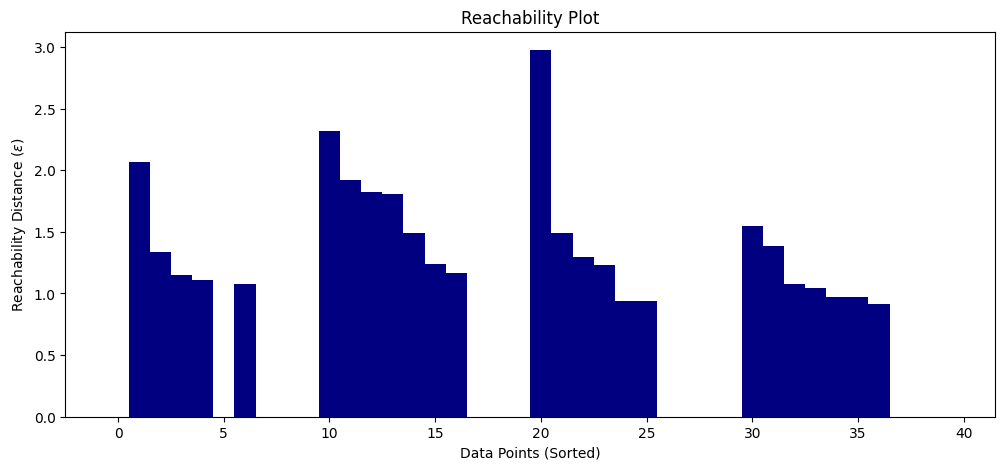

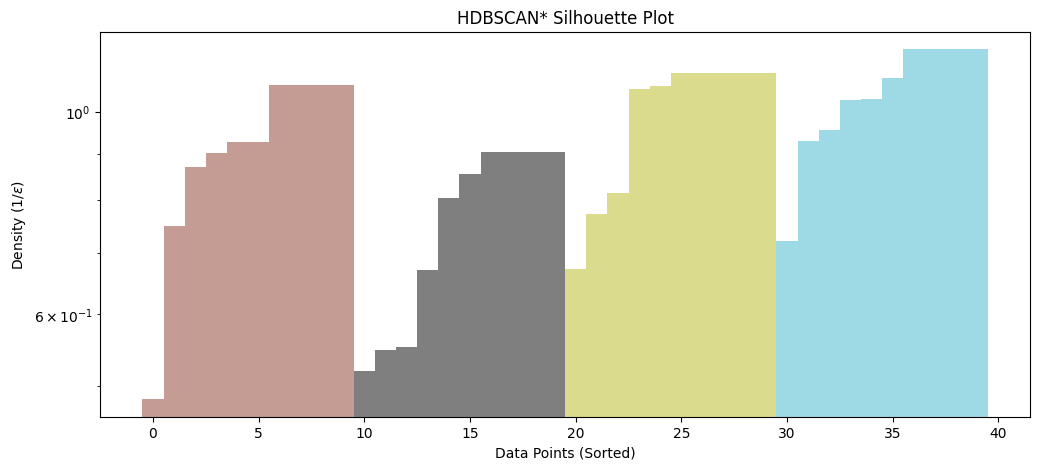

In [69]:
# Prepare Data
ordering, sorted_hierarchy = get_ordering_from_hierarchy(hierarchy)

# Reachability Plot
reach_metrics = calculate_reachability_from_hierarchy(sorted_hierarchy, ordering)
plot_reachability(reach_metrics)

# Silhouette Plot
densities, cluster_ids = calculate_density_silhouette(sorted_hierarchy, ordering)
plot_silhouette(densities, cluster_ids)

Finally, we can visualize the whole hierarchy looking at the dendrogram itself, where we can see the distance at which each branch splits ot at which a point becomes noise.

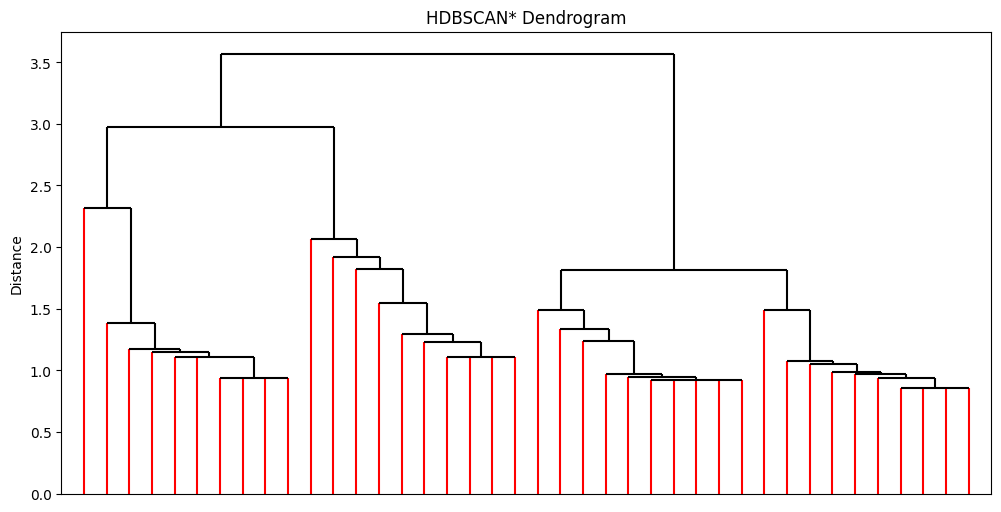

In [70]:
def plot_dendrogram(hierarchy, X, optimal_labels=None, ax=None):
    """
    Plots the dendrogram and colors branches based on the optimal clustering solution.
    """
    if ax is None: fig, ax = plt.subplots(figsize=(12, 6))
    
    n_samples = len(X)
    
    # Color Setup
    # Convert labels to numpy array for easy indexing
    if optimal_labels is not None:
        optimal_labels = np.array(optimal_labels)
        unique_lbls = sorted(list(set(optimal_labels)))
        # Identify valid clusters (assume > 0 is a cluster, 0 is noise)
        valid_clusters = [l for l in unique_lbls if l > 0]
        
        # Create a color map (using tab10 or similar)
        cmap = plt.get_cmap('tab10', max(1, len(valid_clusters)))
        cluster_colors = {lbl: cmap(i) for i, lbl in enumerate(valid_clusters)}
        
        noise_color = 'lightgrey'
        mixed_color = 'black'
    
    def get_segment_color(members):
        """Helper to decide color of a branch based on its members."""
        if optimal_labels is None:
            # Default behavior: Red for leaves (single points), Black for clusters
            return 'red' if len(members) == 1 else 'black'
        
        # Get labels of all points in this branch
        member_indices = list(members)
        labels_in_branch = optimal_labels[member_indices]
        unique_labels = np.unique(labels_in_branch)
        
        # If all points belong to the same valid cluster, return its color
        if len(unique_labels) == 1:
            lbl = unique_labels[0]
            if lbl > 0:
                return cluster_colors.get(lbl, mixed_color)
            else:
                return noise_color # It's pure noise
        
        # If mixed (contains multiple clusters), return neutral
        return mixed_color

    # Handling Infinity for visualization limits
    valid_scales = [s['scale'] for s in hierarchy if np.isfinite(s['scale'])]
    max_finite = max(valid_scales) if valid_scales else 1.0
    top_limit = max_finite * 1.2
    
    # X-Axis Sorting (for visual cleanliness)
    labels_matrix = np.array([step['labels'] for step in hierarchy])
    ordering = np.lexsort(np.flipud(labels_matrix))
    x_coords = {original_idx: x_pos for x_pos, original_idx in enumerate(ordering)}
    
    # Initialize Branches
    snapshots = sorted(hierarchy, key=lambda x: x['scale'])
    active_branches = {}
    
    # Lists to store drawing data
    segments = [] 
    colors = []
    
    # Initialize leaves
    for original_idx in range(n_samples):
        active_branches[-1 - original_idx] = {
            'x': x_coords[original_idx],
            'y': 0.0, 
            'members': {original_idx}
        }

    next_branch_id = 0

    # Process Snapshots
    for step in snapshots:
        raw_scale = step['scale']
        current_scale = raw_scale if np.isfinite(raw_scale) else top_limit
        current_labels = step['labels']
        
        # Identify new groups
        new_groups = {}
        for idx, lbl in enumerate(current_labels):
            if lbl != 0: 
                if lbl not in new_groups: new_groups[lbl] = []
                new_groups[lbl].append(idx)
        
        # Map old branches -> new labels
        transitions = {lbl: [] for lbl in new_groups.keys()}
        
        for branch_key, branch_data in list(active_branches.items()):
            first_member = next(iter(branch_data['members']))
            new_lbl = current_labels[first_member]
            
            if new_lbl != 0:
                if new_lbl in transitions:
                    transitions[new_lbl].append(branch_key)

        # Execute Merges
        for new_lbl, constituent_branches in transitions.items():
            
            if len(constituent_branches) > 0: 
                xs = []
                for bid in constituent_branches:
                    child = active_branches[bid]
                    child_x = child['x']
                    child_y_start = child['y']
                    
                    if current_scale > child_y_start:
                        # Add Vertical Segment
                        segments.append([(child_x, child_y_start), (child_x, current_scale)])
                        # Color logic
                        colors.append(get_segment_color(child['members']))
                    
                    xs.append(child_x)
                
                # Draw Horizontal Bar (Merge line)
                if len(xs) > 1:
                    min_x, max_x = min(xs), max(xs)
                    segments.append([(min_x, current_scale), (max_x, current_scale)])
                    all_members_in_merge = set()
                    for bid in constituent_branches:
                        all_members_in_merge.update(active_branches[bid]['members'])
                    
                    colors.append(get_segment_color(all_members_in_merge))
                
                parent_x = np.mean(xs)
                
                # Update State
                new_members = set()
                for bid in constituent_branches:
                    new_members.update(active_branches[bid]['members'])
                    del active_branches[bid]
                
                active_branches[next_branch_id] = {
                    'x': parent_x,
                    'y': current_scale,
                    'members': new_members
                }
                next_branch_id += 1

    # Finalize (Draw stems to top)
    for bid, branch in active_branches.items():
        if branch['y'] < top_limit:
            segments.append([(branch['x'], branch['y']), (branch['x'], top_limit)])
            colors.append(get_segment_color(branch['members']))

    # Render
    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    ax.add_collection(lc)
    
    ax.set_xlim(-1, n_samples)
    ax.set_ylim(0, top_limit * 1.05)
    
    title = "HDBSCAN* Dendrogram"
    if optimal_labels is not None:
        title += " (Colored by Optimal Clustering)"
    ax.set_title(title)
    ax.set_ylabel("Distance")
    ax.set_xticks([])
    
    return ax

plot_dendrogram(hierarchy, X)
plt.show()